In [202]:
import pandas as pd
import numpy as np
import time
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings

Подход 1: градиентный бустинг "в лоб"

In [203]:
warnings.filterwarnings('ignore') # disable warnings
pd.options.display.max_columns = None # disable restrict 
features = pd.read_csv('./features.csv', index_col='match_id')
arr_feat_loss = []
feat_droped = features.drop(['duration','radiant_win','tower_status_radiant','tower_status_dire','barracks_status_radiant','barracks_status_dire'], axis=1)
for i, name_fe in enumerate(features.columns):
    if (features.count()[i] < len(features.index)): 
        arr_feat_loss.append(name_fe)
print(arr_feat_loss)
feat_droped = feat_droped.fillna(0)

# select all rows
#X_clear = feat_droped # selected wished features
#y_clear = features['radiant_win'] # selected target

# randomize select rows
r = np.random.randint(len(features.index),size=45000)
X_clear = feat_droped.iloc[r,:]
y_clear = features['radiant_win'].iloc[r]

['first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time']


Prepare data № 1 (только scaler):

In [204]:
scaler = StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_clear), index=X_clear.index, columns=X_clear.columns) # convert there and back
y_1 = y_clear

Prepare data № 2 (удаление категориальных признаков + scaler):

In [205]:
X_1 = X_clear.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero'], axis=1)
scaler = StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_1), index=X_1.index, columns=X_1.columns) # convert there and back
y_1 = y_clear

Prepare data № 3 (удаление категориальных признаков + scaler + мешок слов):

In [210]:
X_1 = X_clear.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero'], axis=1)
scaler = StandardScaler()
X_1 = pd.DataFrame(scaler.fit_transform(X_1), index=X_1.index, columns=X_1.columns) # convert there and back
y_1 = y_clear
# N — количество различных героев в выборке
N = len(pd.read_csv('./data/dictionaries/heroes.csv'))
X_pick = np.zeros((X_1.shape[0], N))
for i, match_id in enumerate(X_1.index):
    for p in range(5):
        X_pick[i, X_clear.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_clear.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_p = pd.DataFrame(X_pick, index=X_1.index)
X_1 = pd.concat([X_1, X_p], axis=1, join_axes=[X_1.index]) # add to DataFrame

Time elapsed: 0:08:37.483916
[0.6656910778211926, 0.6842382619919626, 0.6915643473236095, 0.6989535514229421, 0.7025545823967126, 0.7058162240783001, 0.7090081264278469, 0.71001345802821, 0.7128722614764685]


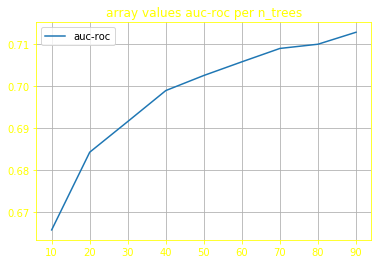

In [181]:
# calculate for different number trees
n_ras = [] # array values auc-roc per n_trees
start_time = datetime.datetime.now() # fstart calculate time
for n_trees in tqdm_notebook(np.arange(10,100,10)):
    gbc = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    ras = [] # array values auc-roc into KFold
    for train_index, test_index in tqdm_notebook(kf.split(X_1)):
        X_train, X_test = X_1.values[train_index], X_1.values[test_index]
        y_train, y_test = y_1.values[train_index], y_1.values[test_index]
        gbc.fit(X_train, y_train)
        y_scores = gbc.predict_proba(X_test)[:, 1]
        ras.append(roc_auc_score(y_test, y_scores, average='samples'))
    n_ras.append(np.mean(ras))
print('Time elapsed:', datetime.datetime.now() - start_time) # stop calculate time    
print(n_ras)
plt.title('array values auc-roc per n_trees', color='yellow')
plt.rc('axes',edgecolor='yellow')
plt.rcParams['xtick.color'] = 'yellow'
plt.rcParams['ytick.color'] = 'yellow'
plt.plot(np.arange(10,100,10),n_ras) # for line
plt.legend(['auc-roc'], loc='upper left')
plt.grid(True)

In [200]:
# calculate time for 30 trees
start_time = datetime.datetime.now() # fstart calculate time
gbc = GradientBoostingClassifier(n_estimators=30, random_state=42)
kf = KFold(n_splits=5, shuffle=True)
ras = [] # array values auc-roc into KFold
for train_index, test_index in tqdm_notebook(kf.split(X_1)):
    X_train, X_test = X_1.values[train_index], X_1.values[test_index]
    y_train, y_test = y_1.values[train_index], y_1.values[test_index]
    gbc.fit(X_train, y_train)
    y_scores = gbc.predict_proba(X_test)[:, 1]
    ras.append(roc_auc_score(y_test, y_scores, average='samples'))
print('Time elapsed for 30 trees:', datetime.datetime.now() - start_time) # stop calculate time    
print('Score AUC-ROC: ', np.mean(ras))


Time elapsed for 30 trees: 0:01:04.302799
Score AUC-ROC:  0.692805087662442


Отчёт № 1 :
1. пропуски имеют следующие признаки: 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time'.
Основная причина пропусков - в течение первых пяти минут не всегда успевают произойти определённые события. Например, аннигиляция соперников и приобретения предметов (first_blood_time, first_blood_player1, dire_bottle_time etc.)
2. Целевую переменную содержит столбец 'radiant_win'
3. Time elapsed for 30 trees: 0:01:23.987412 ; Score AUC-ROC:  0.6893316710163322 (взята полная выборка объектов)
4. Если применять градиентный бустинг к данной задаче, то при увеличении числа деревьев качество всё время повышается 
(в цикле от 10 до 90 деревьев оптимум не достигнут). Делать больше, чем 30 деревьев смысл есть, и для ускорения работы алгоритма можно упростить модель (уменьшить max_depth), брать лишь часть объектов для обучения. Для данного анализа была случайно отобрана треть выборки, длительность расчёта - 'Time elapsed: 0:05:31.306915'

Подход 2: логистическая регрессия

Time elapsed: 0:01:32.468142
C = 0.1
AUC_ROC = 0.7491733006273021


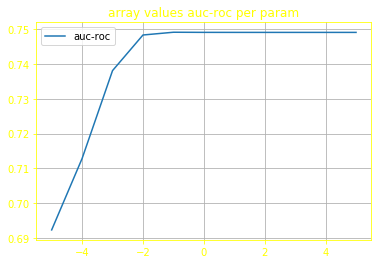

In [211]:
# Logistic Regression (with change parameter C)
n_ras = [] # array values auc-roc per param
start_time = datetime.datetime.now() # fstart calculate time
C_pow_range = range(-5, 6)
C_range = [10.0 ** i for i in C_pow_range]
for param in tqdm_notebook(C_range):
    logreg = LogisticRegression(penalty='l2', C=param, solver='liblinear', random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    ras = [] # array values auc-roc into KFold
    for train_index, test_index in kf.split(X_1):
        X_train, X_test = X_1.values[train_index], X_1.values[test_index]
        y_train, y_test = y_1.values[train_index], y_1.values[test_index]
        coef_ = logreg.fit(X_train, y_train)
        y_scores = logreg.predict_proba(X_test)[:, 1]
        ras.append(roc_auc_score(y_test, y_scores, average='samples'))
    n_ras.append(np.mean(ras))
print('Time elapsed:', datetime.datetime.now() - start_time) # stop calculate time    
plt.title('array values auc-roc per param', color='yellow')
plt.rc('axes',edgecolor='yellow')
plt.rcParams['xtick.color'] = 'yellow'
plt.rcParams['ytick.color'] = 'yellow'
plt.plot(C_pow_range,n_ras) # for line
plt.legend(['auc-roc'], loc='upper left')
plt.grid(True)
max_sc = max(n_ras)
max_sc_ind = n_ras.index(max_sc)
print('C =',C_range[max_sc_ind])
print('AUC_ROC =',max_sc)

Отчёт № 2 :
1. Time elapsed: 0:00:50.507989, C = 0.01, AUC_ROC = 0.7160638917630875 ; И для градиентного бустинга: Time elapsed: 0:08:37.483916, AUC_ROC = 0.7128722614764685, n_trees = 90. Качество логистической регресии при оптимальном параметре регуляризации примерно равно качеству градиентного бустинга на большом количестве деревьев (90), а работает намного быстрее.
2. После удаления категориальных признаков качество существенно не изменилось (AUC_ROC = 0.7157740267683506). Алгоритм к ним оказался устойчив.
3. N = pd.read_csv('./data/dictionaries/heroes.csv'). 112 различных героев
4. При добавлении "мешка слов" качество выросло (AUC_ROC = 0.7491733006273021, при С = 0.1). Это связано с появлением дополнительной релевантной информации в виде разреженной матрицы, которая хорошо обрабатывается данным алгоритмом.
5. predict_min =  0.010685909693386246, predict_max =  0.9970000223919274

* анализ производился для 45000 объектов обучающей выборки. Сокращение выборки сделано с целью ускорения вычислений.

Прогноз для тестовой выборки:

In [244]:
# load test-data and prepare
test = pd.read_csv('./data/features_test.csv', index_col='match_id')
test_prep = test.fillna(0)
X_1_t = test_prep.drop(['lobby_type','r1_hero','r2_hero','r3_hero','r4_hero','r5_hero','d1_hero','d2_hero','d3_hero','d4_hero','d5_hero'], axis=1)
scaler = StandardScaler()
X_1_t = pd.DataFrame(scaler.fit_transform(X_1_t), index=X_1_t.index, columns=X_1_t.columns) # convert there and back
# N — количество различных героев в выборке
N = len(pd.read_csv('./data/dictionaries/heroes.csv'))
X_pick = np.zeros((X_1_t.shape[0], N))
for i, match_id in enumerate(X_1_t.index):
    for p in range(5):
        X_pick[i, test_prep.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, test_prep.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_p_t = pd.DataFrame(X_pick, index=X_1_t.index)
X_1_t = pd.concat([X_1_t, X_p_t], axis=1, join_axes=[X_1_t.index]) # add to DataFrame

# fit model
best_model = LogisticRegression(C=0.1, random_state=42)
best_model.fit(X_1, y_1)
y_test = best_model.predict_proba(X_1_t)[:, 1]
answ = pd.DataFrame({'radiant_win': y_test}, index=X_1_t.index)
answ.index.name = 'match_id'
answ.to_csv('./answers_final/answ.csv')
print('predict_max = ',float(answ.max().values))
print('predict_min = ',float(answ.min().values))
display(answ)

predict_max =  0.9970000223919274
predict_min =  0.010685909693386246


,radiant_win
match_id,
6,0.807805
7,0.718602
10,0.178821
13,0.876573
16,0.280858
18,0.326273
19,0.498932
24,0.562708
33,0.213019
